Running NHC with M = 1
[M=1] Step 0 | T=1.4574
[M=1] Step 2000 | T=1.2709
[M=1] Step 4000 | T=1.4911
[M=1] Step 6000 | T=1.6226
[M=1] Step 8000 | T=1.5406
[M=1] Step 10000 | T=1.5448
[M=1] Step 12000 | T=1.5759
[M=1] Step 14000 | T=1.4352
[M=1] Step 16000 | T=1.5666
[M=1] Step 18000 | T=1.5086
Running NHC with M = 2
[M=2] Step 0 | T=1.5022
[M=2] Step 2000 | T=1.3445
[M=2] Step 4000 | T=1.5153
[M=2] Step 6000 | T=1.4624
[M=2] Step 8000 | T=1.4851
[M=2] Step 10000 | T=1.5599
[M=2] Step 12000 | T=1.5626
[M=2] Step 14000 | T=1.4836
[M=2] Step 16000 | T=1.5233
[M=2] Step 18000 | T=1.4512
Running NHC with M = 3
[M=3] Step 0 | T=1.4707
[M=3] Step 2000 | T=1.3493
[M=3] Step 4000 | T=1.6028
[M=3] Step 6000 | T=1.6581
[M=3] Step 8000 | T=1.6696
[M=3] Step 10000 | T=1.3652
[M=3] Step 12000 | T=1.4934
[M=3] Step 14000 | T=1.4375
[M=3] Step 16000 | T=1.5869
[M=3] Step 18000 | T=1.4803
Running NHC with M = 4
[M=4] Step 0 | T=1.4497
[M=4] Step 2000 | T=1.3927
[M=4] Step 4000 | T=1.5826
[M=4] Step 600

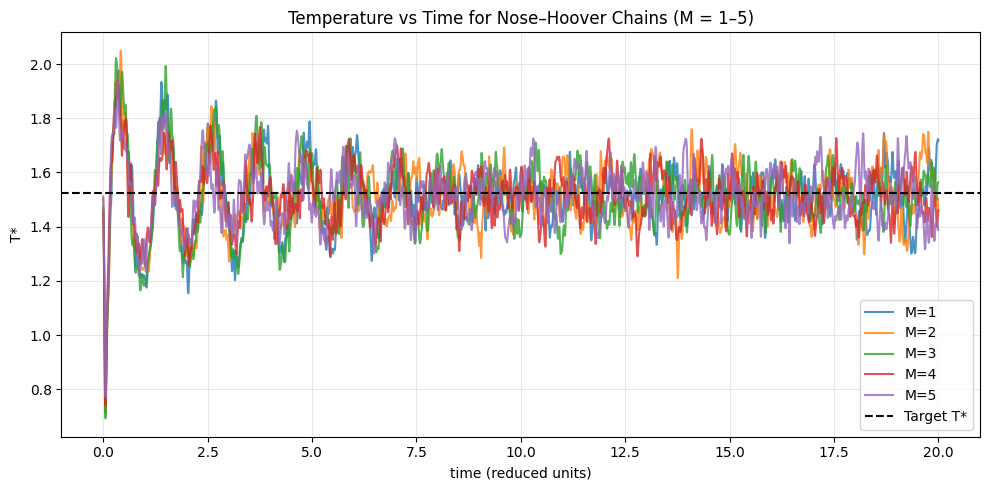

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rc = 2.5
rc2 = rc * rc


def apply_pbc(r, L):
    return (r + L / 2.0) % L - L / 2.0

def compute_forces_LJ(r, L):
    N = r.shape[0]
    F = np.zeros_like(r)
    PE = 0.0
    for i in range(N - 1):
        rij = r[i] - r[i+1:]
        rij -= L * np.rint(rij / L)
        r2 = np.sum(rij**2, axis=1)
        m = r2 < rc2
        if not np.any(m):
            continue
        rij = rij[m]
        r2  = r2[m]
        inv2  = 1.0 / r2
        inv6  = inv2**3
        inv12 = inv6**2
        PE += np.sum(4.0 * (inv12 - inv6))
        f_scalar = (48.0 * inv12 - 24.0 * inv6) * inv2
        fij = f_scalar[:, None] * rij
        F[i]       += np.sum(fij, axis=0)
        F[i+1:][m] -= fij
    return F, PE

def kinetic_energy(v):
    return 0.5 * np.sum(v * v)

def temperature_inst(K, N):
    return (2.0 / 3.0) * (K / N)

def nhc_step(v, r, F, xi, Q, dt, L, T_target, dof):
    M = len(xi)
    g = np.ones(M)
    g[0] = dof
    K = kinetic_energy(v)
    G = np.zeros(M)
    G[0] = (2.0 * K - g[0] * T_target)
    for j in range(1, M):
        G[j] = Q[j-1] * xi[j-1]**2 - g[j] * T_target
    for j in reversed(range(1, M)):
        xi[j] += 0.5 * dt * G[j] / Q[j]
    xi[0] += 0.5 * dt * G[0] / Q[0]
    v *= np.exp(-0.5 * xi[0] * dt)
    v += 0.5 * dt * F
    r += dt * v
    r = apply_pbc(r, L)
    F, PE = compute_forces_LJ(r, L)
    v += 0.5 * dt * F
    K = kinetic_energy(v)
    G[0] = (2.0 * K - g[0] * T_target)
    xi[0] += 0.5 * dt * G[0] / Q[0]
    for j in range(1, M):
        G[j] = Q[j-1] * xi[j-1]**2 - g[j] * T_target
        xi[j] += 0.5 * dt * G[j] / Q[j]
    v *= np.exp(-0.5 * xi[0] * dt)
    return v, r, F, xi, PE

def run_nhc(chain_length, steps=20000, print_interval=2000):
    N = 216
    rho = 0.8442
    T_target = 1.5228
    dt = 20.0 / steps
    L = (N / rho)**(1.0 / 3.0)
    n3 = int(np.ceil(N**(1.0 / 3.0)))
    a = L / n3
    r_list = []
    for i in range(n3):
        for j in range(n3):
            for k in range(n3):
                if len(r_list) < N:
                    r_list.append([-L/2 + a/2 + i*a,
                                   -L/2 + a/2 + j*a,
                                   -L/2 + a/2 + k*a])
    r = np.array(r_list)
    v = np.random.normal(0, np.sqrt(T_target), size=(N,3))
    v -= v.mean(axis=0)
    F, PE = compute_forces_LJ(r, L)
    dof = 3*N - 3
    tau = 0.2
    xi  = np.zeros(chain_length)
    Q = np.zeros(chain_length)
    Q[0] = dof * T_target * tau**2
    for j in range(1, chain_length):
        Q[j] = T_target * tau**2
    T_list = []
    for s in range(steps):
        K = kinetic_energy(v)
        T = temperature_inst(K, N)
        T_list.append(T)
        if s % print_interval == 0:
            print(f"[M={chain_length}] Step {s} | T={T:.4f}")
        v, r, F, xi, PE = nhc_step(v, r, F, xi, Q, dt, L, T_target, dof)
    return np.array(T_list), dt

np.random.seed(42)
chain_lengths = [1, 2, 3, 4, 5]
results = {}

for M in chain_lengths:
    print(f"Running NHC with M = {M}")
    T, dt = run_nhc(M)
    results[M] = (T, dt)

plt.figure(figsize=(10,5))
for M in chain_lengths:
    T, dt = results[M]
    t = np.arange(len(T)) * dt
    plt.plot(t, T, label=f"M={M}", alpha=0.8)

plt.axhline(1.5228, color='k', linestyle='--', label="Target T*")
plt.xlabel("time (reduced units)")
plt.ylabel("T*")
plt.title("Temperature vs Time for Nose–Hoover Chains (M = 1–5)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()